In [1]:
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    get_vertical_discretization_frequency,get_nanotem_wave,
    set_mesh_1d
)
import numpy as np
import pandas as pd
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## load TEMFAST data

In [2]:
temfast_data = pd.read_table(os.path.sep.join(['./', 'dados.txt']))  #Load data file
fname = 'T1P1_11_11_01'
fnameinv = fname+'_inv'
fnameforw = fname+'_forw'
fnameconduc = fname+'_coduct'

## plot data

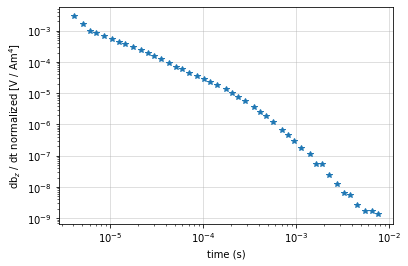

In [3]:
#Plot real data 
size_loop = 25 
loop_area = size_loop**2
neg_dobs = temfast_data[(temfast_data['E_I'] < 0 )].index
temfast_data.drop(neg_dobs, inplace = True) #drops negative values
time_channels = (temfast_data.Time[:].values)*1e-6  # deleted the last 4 values 
dobs = temfast_data.E_I[:].values/loop_area # [V/Am4]
dobs = dobs #[V/Am^2]

fig, ax = plt.subplots(1, 1)
ax.loglog(time_channels, dobs, '*')
ax.set_xlabel("time (s)")
ax.set_ylabel("db$_z$ / dt normalized [V / Am$^4$]")
ax.grid("k", alpha=0.5)
ax.set_rasterized(True)

## set the current waveform

In [4]:
waveform = np.vstack([
    np.r_[-3.44e-7, -3.28e-7, -3.20e-7, -3.04e-7, -2.88e-7, -2.24e-7, -1.92e-7, -9.60e-8, -8.80e-8, 0.0, 1.12e-7, 2.24e-7, 
         3.52e-7, 4.80e-7, 6.00e-7, 7.60e-7, 1.10e-6, 1.22e-6, 1.46e-5],
    np.r_[0, 30, 50, 62, 72, 92, 96, 99, 100, 100, 85, 60, 40, 31, 20, 11, 2,  0, 0]/100.
]).T

time_input_currents = waveform[:, 0]
input_currents = waveform[:, 1]
radius = np.sqrt(loop_area/np.pi)
srcloc = np.array([0., 0., 0.], dtype=float) # source coord
rxloc = np.array([0., 0., 0.], dtype=float) # source coord
times = time_channels

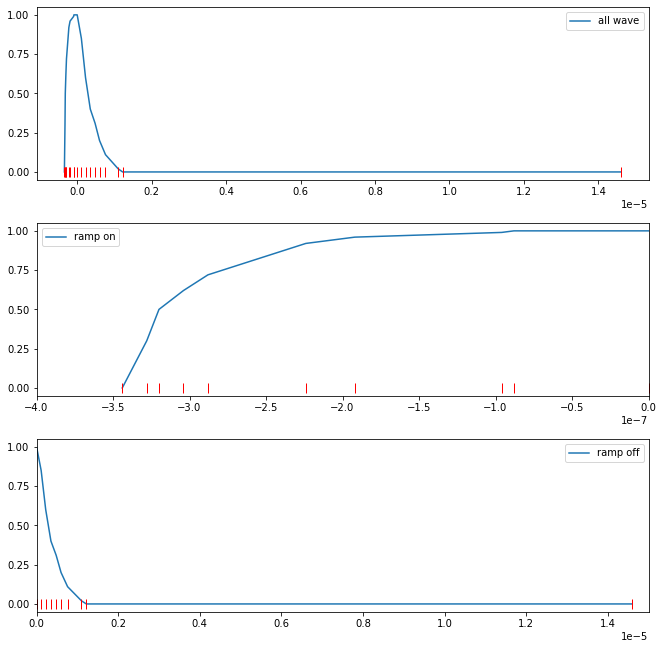

In [5]:
fig,ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(time_input_currents, input_currents,label='all wave')
ax[0].plot(time_input_currents, np.zeros(len(time_input_currents)), 'r|', ms=10)
#ax.plot(time_channels,0.1*np.ones(len(time_channels)),'*',label='time channels')
#ax[0].set_xlim([0,10e-6])
ax[0].legend()

ax[1].plot(time_input_currents, input_currents,label='ramp on')
ax[1].plot(time_input_currents, np.zeros(len(time_input_currents)), 'r|', ms=10)
#ax.plot(time_channels,0.1*np.ones(len(time_channels)),'*',label='time channels')
ax[1].set_xlim([-4e-7,0])
ax[1].legend()

ax[2].plot(time_input_currents, input_currents,label='ramp off')
ax[2].plot(time_input_currents, np.zeros(len(time_input_currents)), 'r|', ms=10)
#ax.plot(time_channels,0.1*np.ones(len(time_channels)),'*',label='time channels')
ax[2].set_xlim([0,1.5e-5])
ax[2].legend()

plt.rcParams.update({'font.size': 16})
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

## set survey and problem

In [6]:
from simpegEM1D import skytem_HM_2015
frequency_mesh = np.array([100., 382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency_mesh, sigma_background=0.01, factor_fmax=5, n_layer=40)
#hz = get_vertical_discretization_time(times, facter_tmax=1, n_layer=40)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
TDsurvey = EM1DSurveyTD(
    rx_location = rxloc,
    src_location = srcloc,
    topo = np.r_[0., 0., 0.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = radius,
    time = time_channels,
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency=50,
    n_pulse=1
)
expmap = Maps.ExpMap(mesh1D)
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
std = 0.05
floor = 0.
TDsurvey.dobs = -dobs
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
uncert = (abs(TDsurvey.dobs)*std+floor)
dmisfit.W = 1./ uncert
m0 = np.log(np.ones_like(hz)*1/3.)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [7]:
dpred = TDsurvey.dpred(m0)

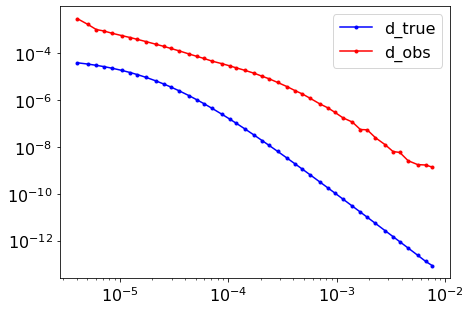

In [8]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -dpred, 'b.-',label = 'd_true')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'r.-',label = 'd_obs')
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend()

## run inversion

In [9]:
reg = Regularization.Tikhonov(
    mesh1D,
    mapping=Maps.IdentityMap(mesh1D),
    alpha_s=1.,
    alpha_x=1.
)
opt = Optimization.ProjectedGNCG(maxIter=25, maxIterCG=20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [10]:
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.14e-03  8.63e+03  0.00e+00  8.63e+03    1.09e+02      0              
   1  2.07e-03  8.46e+03  3.22e+02  8.46e+03    2.69e+02      4              
   2  1.04e-03  8.12e+03  4.75e+03  8.13e+03    2.06e+02      2              
   3  5.18e-04  8.10e+03  8.87e+03  8.10e+03    3.75e+01      2              
   4  2.59e-04  8.10e+03  2.30e+03  8.10e+03    3.98e+01      1              
   5  1.29e-04  8.10e+03  6.62e+02  8.10e+03    4.09e+01      1              
   6  6.47e-05  8.10e+03  4.24e+02  8.10e+03    2.24e+00      2   

Text(0.5, 0, 'Resistivity (ohm-m)')

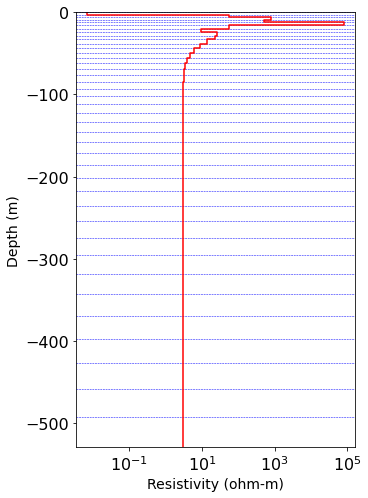

In [11]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./(expmap*mopt), mesh1D, showlayers=True, **{'color':'r'})
plt.xlabel("Resistivity (ohm-m)")
# Utils1D.plotLayer(expmap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1.})

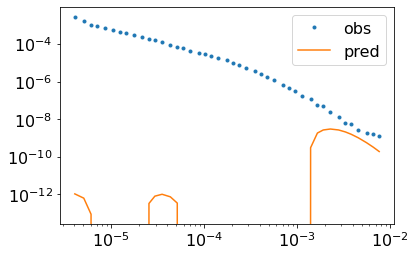

In [12]:
plt.loglog(time_channels, -TDsurvey.dobs, '.')
plt.loglog(time_channels, -invProb.dpred)
plt.legend(("obs", "pred"))



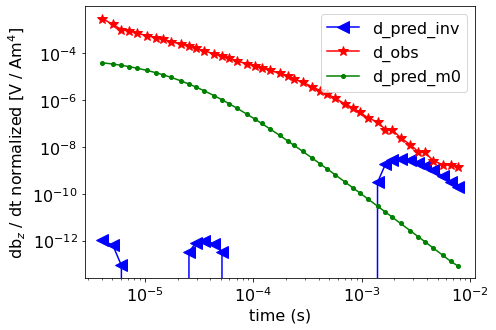

In [13]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b<-',ms=12,label = 'd_pred_inv')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'r*-',ms=10,label = 'd_obs')
axes.plot(TDsurvey.time,-dpred,'g.-',ms=8,label = 'd_pred_m0')
axes.set_xscale('log');
axes.set_xlabel("time (s)")
axes.set_ylabel("db$_z$ / dt normalized [V / Am$^4$]")
axes.set_yscale('log');
plt.legend()